# MiniTokenNLP – Custom Tokenizer & Embedding Visualization

**Goal:** Build a minimal tokenizer and embedding layer from scratch, visualize the resulting feature space, and interpret patterns in word representations.

## 1. Introduction
This notebook demonstrates how text data can be numerically represented through tokenization and embedding.

Steps:
1. Load and clean movie review texts.
2. Build a simple tokenizer from scratch.
3. Construct random embeddings for each word.
4. Visualize the embedding space.
5. Discuss what these visualizations reveal about language representation.

## 2. Dataset Preparation
We use NLTK's `movie_reviews` dataset which contains 2000 labeled reviews.

In [12]:
import nltk
nltk.data.path.append("./nltk_data")
from nltk.corpus import movie_reviews
import random

# Load dataset
documents = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]
random.shuffle(documents)

print(documents[0])

(['this', 'film', 'is', 'extraordinarily', 'horrendous', 'and', 'i', "'", 'm', 'not', 'going', 'to', 'waste', 'any', 'more', 'words', 'on', 'it', '.'], 'neg')


## 3. Text Cleaning
To make the vocabulary more meaningful, we:
- Lowercase all words
- Remove punctuation and stopwords
- Keep alphabetic tokens only

In [13]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(words):
    return [w.lower() for w in words if w.isalpha() and w.lower() not in stop_words]

cleaned_texts = [clean_text(words) for words, _ in documents]

print(cleaned_texts[0])

['film', 'extraordinarily', 'horrendous', 'going', 'waste', 'words']


## 4. Custom Tokenizer
We build a simple word-level tokenizer that constructs a vocabulary and assigns each word an integer ID.

In [14]:
from collections import Counter

# Define a simple word-level tokenizer class
class MiniTokenizer:
    def __init__(self, min_freq=3):
        """
        Initialize the tokenizer.
        :arg min_freq(int): minimum frequency a word must have to be included in the vocabulary.
        """
        self.min_freq = min_freq
        # Initialize vocabulary with two special tokens:
        # <PAD> for padding and <UNK> for unknown (out-of-vocabulary) words.
        self.word2id = {"<PAD>": 0, "<UNK>": 1}
        self.id2word = {0: "<PAD>", 1: "<UNK>"}

    def fit(self, texts):
        """
        Build the vocabulary from the training corpus.
        :arg texts: list of tokenized sentences.
        """
        # Count the frequency of each word across all texts
        freq = Counter([w for text in texts for w in text])
        # Add words that meet the frequency threshold to the vocabulary
        for w, c in freq.items():
            if c >= self.min_freq:
                idx = len(self.word2id)
                self.word2id[w] = idx
                self.id2word[idx] = w

    def encode(self, text):
        """
        Convert a list of tokens into a list of integer IDs.
        Unknown words are mapped to <UNK>.
        """
        return [self.word2id.get(w, 1) for w in text]

tokenizer = MiniTokenizer(min_freq=3)
# Build vocabulary from cleaned training texts
tokenizer.fit(cleaned_texts)
# Check the vocabulary size
vocab_size = len(tokenizer.word2id)
print("Vocabulary size:", vocab_size)

Vocabulary size: 19779


## 4.1 TECHNIQUE 2: Byte-Pair Encoding (BPE) Tokenizer
We also build a BPE Tokenizer.

In [15]:
from pathlib import Path
import json

class BPETokenizer:
    def __init__(self, vocab_size=1000):
        """Initialize BPE tokenizer with specified vocabulary size"""
        self.vocab_size = vocab_size
        self.vocab = {}
        self.merges = {}
        
    def get_stats(self, vocab):
        """Calculate frequency of adjacent symbol pairs"""
        pairs = {}
        for word, freq in vocab.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pair = (symbols[i], symbols[i+1])
                pairs[pair] = pairs.get(pair, 0) + freq
        return pairs
    
    def merge_vocab(self, pair, v_in):
        """Merge the most frequent symbol pair"""
        v_out = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        for word in v_in:
            w_out = word.replace(bigram, replacement)
            v_out[w_out] = v_in[word]
        return v_out
    
    def train(self, texts):
        """Train BPE tokenizer on given texts"""
        print("Starting BPE tokenizer training...")
        
        # Count word frequencies with character-level initialization
        word_freq = {}
        for text in texts:
            for word in text:
                # Convert word to character sequence with end token
                tokenized_word = ' '.join(list(word)) + ' </w>'
                word_freq[tokenized_word] = word_freq.get(tokenized_word, 0) + 1
        
        vocab = word_freq
        
        # Initialize vocabulary with special tokens and all characters
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        for word in vocab:
            for char in word.split():
                if char not in self.vocab:
                    self.vocab[char] = len(self.vocab)
        
        self.merges = {}
        num_merges = self.vocab_size - len(self.vocab)
        
        # BPE merging iterations
        for i in range(num_merges):
            pairs = self.get_stats(vocab)
            if not pairs:
                print(f"No more pairs to merge. Stopped after {i} merges")
                break
                
            best_pair = max(pairs, key=pairs.get)
            best_freq = pairs[best_pair]
            
            if best_freq < 2:  # Stop if frequency is too low
                print(f"Highest pair frequency below 2. Stopped after {i} merges")
                break
                
            # Perform the merge
            vocab = self.merge_vocab(best_pair, vocab)
            self.merges[best_pair] = len(self.vocab)
            merged_token = ''.join(best_pair)
            self.vocab[merged_token] = len(self.vocab)
            
            if (i + 1) % 100 == 0:
                print(f"Completed {i+1}/{num_merges} merges: {best_pair} -> {merged_token}")
        
        print(f"BPE training completed! Final vocabulary size: {len(self.vocab)}")
        print(f"Total merges performed: {len(self.merges)}")
    
    def tokenize(self, word):
        """Tokenize a single word using BPE"""
        if word in self.vocab:
            return [word]
            
        # Initialize as character sequence
        tokens = list(word) + ['</w>']
        
        # Apply merge rules
        while len(tokens) > 1:
            pairs = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1)]
            possible_merges = []
            
            for pair in pairs:
                if pair in self.merges:
                    possible_merges.append((self.merges[pair], pair))
            
            if not possible_merges:
                break
                
            # Select the pair with smallest merge index (earliest learned)
            _, best_pair = min(possible_merges)
            
            # Perform the merge
            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == best_pair:
                    new_tokens.append(tokens[i] + tokens[i+1])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens
        
        return tokens
    
    def encode(self, text):
        """Encode a list of words into token IDs"""
        token_ids = []
        for word in text:
            tokens = self.tokenize(word)
            for token in tokens:
                token_ids.append(self.vocab.get(token, self.vocab['<UNK>']))
        return token_ids

In [16]:
# --- Train and Test BPE Tokenizer ---
print("Training BPE tokenizer...")
bpe_tokenizer = BPETokenizer(vocab_size=800)
bpe_tokenizer.train(cleaned_texts)

# Test BPE tokenizer
test_words = ["playing", "unbelievable", "didn't", "happily", "actors"]
print("\nBPE Tokenization Examples:")
for word in test_words:
    tokens = bpe_tokenizer.tokenize(word)
    print(f"  '{word}' -> {tokens}")

# Test encoding functionality
print("\nBPE Encoding Examples:")
test_sentences = [
    ["I", "don't", "like", "this", "movie"],
    ["The", "actors", "were", "excellent"]
]

for i, sentence in enumerate(test_sentences):
    token_ids = bpe_tokenizer.encode(sentence)
    print(f"  Sentence {i+1}: {sentence}")
    print(f"  Encoded IDs: {token_ids}")
    print()

Training BPE tokenizer...
Starting BPE tokenizer training...
Completed 100/771 merges: ('e', 'm') -> em
Completed 200/771 merges: ('s', 'o</w>') -> so</w>
Completed 300/771 merges: ('ma', 'kes</w>') -> makes</w>
Completed 400/771 merges: ('youn', 'g</w>') -> young</w>
Completed 500/771 merges: ('ou', 't') -> out
Completed 600/771 merges: ('su', 'al</w>') -> sual</w>
Completed 700/771 merges: ('ex', 'am') -> exam
BPE training completed! Final vocabulary size: 800
Total merges performed: 771

BPE Tokenization Examples:
  'playing' -> ['playing</w>']
  'unbelievable' -> ['un', 'be', 'li', 'ev', 'a', 'ble</w>']
  'didn't' -> ['di', 'd', 'n', "'", 't</w>']
  'happily' -> ['hap', 'p', 'il', 'y</w>']
  'actors' -> ['ac', 't', 'or', 's</w>']

BPE Encoding Examples:
  Sentence 1: ['I', "don't", 'like', 'this', 'movie']
  Encoded IDs: [1, 6, 13, 37, 1, 35, 151, 50, 3, 30, 118]

  Sentence 2: ['The', 'actors', 'were', 'excellent']
  Encoded IDs: [1, 16, 29, 53, 9, 44, 30, 20, 32, 29, 103, 25, 61,

## 5. Technique Comparison and Data Saving

TECHNIQUE COMPARISON: Word-Level vs BPE

In [17]:
# Comparison testing
test_sentences = [
    "I don't like this unbelievable movie",
    "The actors were playing wonderfully"
]

print("Tokenization Comparison Demo:")
print("-" * 50)

for i, sentence in enumerate(test_sentences, 1):
    print(f"Sentence {i}: '{sentence}'")
    
    # Word-Level tokenization
    word_tokens = sentence.lower().split()
    word_ids = tokenizer.encode(word_tokens)
    print(f"  Word-Level: {word_tokens}")
    
    # BPE tokenization
    bpe_tokens = []
    for word in sentence.lower().split():
        bpe_tokens.extend(bpe_tokenizer.tokenize(word))
    print(f"  BPE:        {bpe_tokens}")
    print()

# Save BPE vocabulary
print("Saving BPE tokenizer...")
bpe_out_dir = Path("artifacts/tokenizer_bpe")
bpe_out_dir.mkdir(parents=True, exist_ok=True)

bpe_meta = {
    "type": "bpe",
    "vocab_size": len(bpe_tokenizer.vocab),
    "merges_count": len(bpe_tokenizer.merges),
    "vocab": bpe_tokenizer.vocab,
    "merges": list(bpe_tokenizer.merges.keys())
}

(bpe_out_dir / "bpe_model.json").write_text(json.dumps(bpe_meta, indent=2))
print(f"BPE model saved to: {bpe_out_dir / 'bpe_model.json'}")

Tokenization Comparison Demo:
--------------------------------------------------
Sentence 1: 'I don't like this unbelievable movie'
  Word-Level: ['i', "don't", 'like', 'this', 'unbelievable', 'movie']
  BPE:        ['i', 'd', 'on', "'", 't</w>', 'like</w>', 'th', 'i', 's</w>', 'un', 'be', 'li', 'ev', 'a', 'ble</w>', 'movie</w>']

Sentence 2: 'The actors were playing wonderfully'
  Word-Level: ['the', 'actors', 'were', 'playing', 'wonderfully']
  BPE:        ['th', 'e</w>', 'ac', 't', 'or', 's</w>', 'w', 'er', 'e</w>', 'playing</w>', 'won', 'd', 'er', 'fully</w>']

Saving BPE tokenizer...
BPE model saved to: artifacts\tokenizer_bpe\bpe_model.json


## 6. Final Technique Comparison and Selection
FINAL TECHNIQUE COMPARISON AND SELECTION

In [18]:
# Create comparison table
comparison_data = {
    'Metric': ['Vocabulary Size', 'OOV Handling', 'Subword Units', 'Implementation Complexity', 'Best Use Case'],
    'Word-Level': [
        f"{len(tokenizer.word2id)}", 
        'Poor (uses <UNK>)', 
        'No', 
        'Low', 
        'Baseline tasks'
    ],
    'BPE': [
        f"{len(bpe_tokenizer.vocab)}", 
        'Good', 
        'Yes', 
        'Medium', 
        'Subword tasks'
    ]
}

# Print comparison table
print(f"{'Metric':<25} | {'Word-Level':<20} | {'BPE':<20}")
print("-" * 75)
for i in range(len(comparison_data['Metric'])):
    metric = comparison_data['Metric'][i]
    word_val = comparison_data['Word-Level'][i]
    bpe_val = comparison_data['BPE'][i]
    print(f"{metric:<25} | {word_val:<20} | {bpe_val:<20}")



Metric                    | Word-Level           | BPE                 
---------------------------------------------------------------------------
Vocabulary Size           | 19779                | 800                 
OOV Handling              | Poor (uses <UNK>)    | Good                
Subword Units             | No                   | Yes                 
Implementation Complexity | Low                  | Medium              
Best Use Case             | Baseline tasks       | Subword tasks       


## GROUP DECISION: We select Word-Level tokenizer as our final solution
Reasoning:
1. Word-Level tokenizer provides a solid baseline with 19,779 vocabulary size
2. For movie review sentiment analysis, most words are common English words
3. The simplicity of word-level tokenization allows us to focus on model architecture
4. BPE shows excellent subword handling but adds complexity for this specific task
5. The performance gain from BPE does not justify the added complexity for sentiment analysis
""")

## 7. Embedding Construction
We assign each word a random embedding vector of dimension 50.
Though not trained, this embedding allows us to visualize the structure of the vocabulary in a continuous space.

In [19]:
import numpy as np

# Set the dimensionality of the embedding vectors
embedding_dim = 50 # Each word will be represented by a 50-dimensional vector
# Initialize a random embedding matrix
# Shape: (vocab_size, embedding_dim)
# Each row corresponds to one word in the vocabulary,
# and each column represents one "feature" of that word's semantic meaning.
embedding_matrix = np.random.uniform(
    low=-0.01, # Lower bound for random initialization
    high=0.01, # Upper bound
    size=(vocab_size, embedding_dim)
)

## 8. Generate Sentence Embeddings and Export Data

After building the tokenizer and embedding matrix, we now transform each text review into a numerical representation that can be used by other models.

Steps:
1. Encode each cleaned review into token IDs using our custom tokenizer.
2. Pad or truncate each sequence to a fixed length (for consistency).
3. Use the embedding matrix to map token IDs to dense vectors.
4. Average each sentence's word embeddings into a single 50-dimensional vector.
5. Export the resulting embeddings and labels to CSV files, so other notebooks in the group can train models using the same processed data.

In [20]:
# -------------------------------------------------
# Step 6.1: Encode and Pad Token Sequences
# -------------------------------------------------

import numpy as np

def pad_sequence(seq, max_len):
    """
    Pads or truncates a tokenized sentence to a fixed length.
    Shorter sequences are padded with zeros (<PAD> = 0),
    and longer ones are truncated.
    """
    return seq[:max_len] + [0] * (max_len - len(seq))

# Set a reasonable maximum length for each review
max_len = 200

# Convert each cleaned text to a sequence of token IDs
X_encoded = [pad_sequence(tokenizer.encode(text), max_len) for text in cleaned_texts]

print("Example encoded review:", X_encoded[0][:20])
print("Total encoded samples:", len(X_encoded))

Example encoded review: [2, 3, 4, 5, 6, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Total encoded samples: 2000


In [21]:
# -------------------------------------------------
# Step 6.2: Split Encoded Data into Train and Test Sets
# -------------------------------------------------

# 80% training, 20% testing
train_size = int(0.8 * len(X_encoded))

# Convert lists to numpy arrays for easier handling
X_train_seq = np.array(X_encoded[:train_size])
X_test_seq = np.array(X_encoded[train_size:])

# Convert labels ("pos"/"neg") into binary form (1/0)
y_train = np.array([1 if label == 'pos' else 0 for _, label in documents[:train_size]])
y_test = np.array([1 if label == 'pos' else 0 for _, label in documents[train_size:]])

print("Train set shape:", X_train_seq.shape)
print("Test set shape:", X_test_seq.shape)
print("Example label distribution:", np.bincount(y_train))

Train set shape: (1600, 200)
Test set shape: (400, 200)
Example label distribution: [793 807]


## 9. Inspect Vocabulary
Let's look at a few words and their corresponding IDs.


In [22]:
print(list(tokenizer.word2id.items())[:10])

[('<PAD>', 0), ('<UNK>', 1), ('film', 2), ('extraordinarily', 3), ('horrendous', 4), ('going', 5), ('waste', 6), ('words', 7), ('alex', 8), ('browning', 9)]


## 10. Visualize Word Embeddings with PCA & t-SNE
We use PCA to project the 50-dimensional embedding vectors into 2D for visualization.

In [23]:
# To avoid overcrowded plots, we randomly pick 300 words from the vocabulary.
subset_size = 300
subset_ids = random.sample(range(2, vocab_size), subset_size)  # skip <PAD> and <UNK>
subset_words = [tokenizer.id2word[i] for i in subset_ids]
subset_vectors = embedding_matrix[subset_ids]

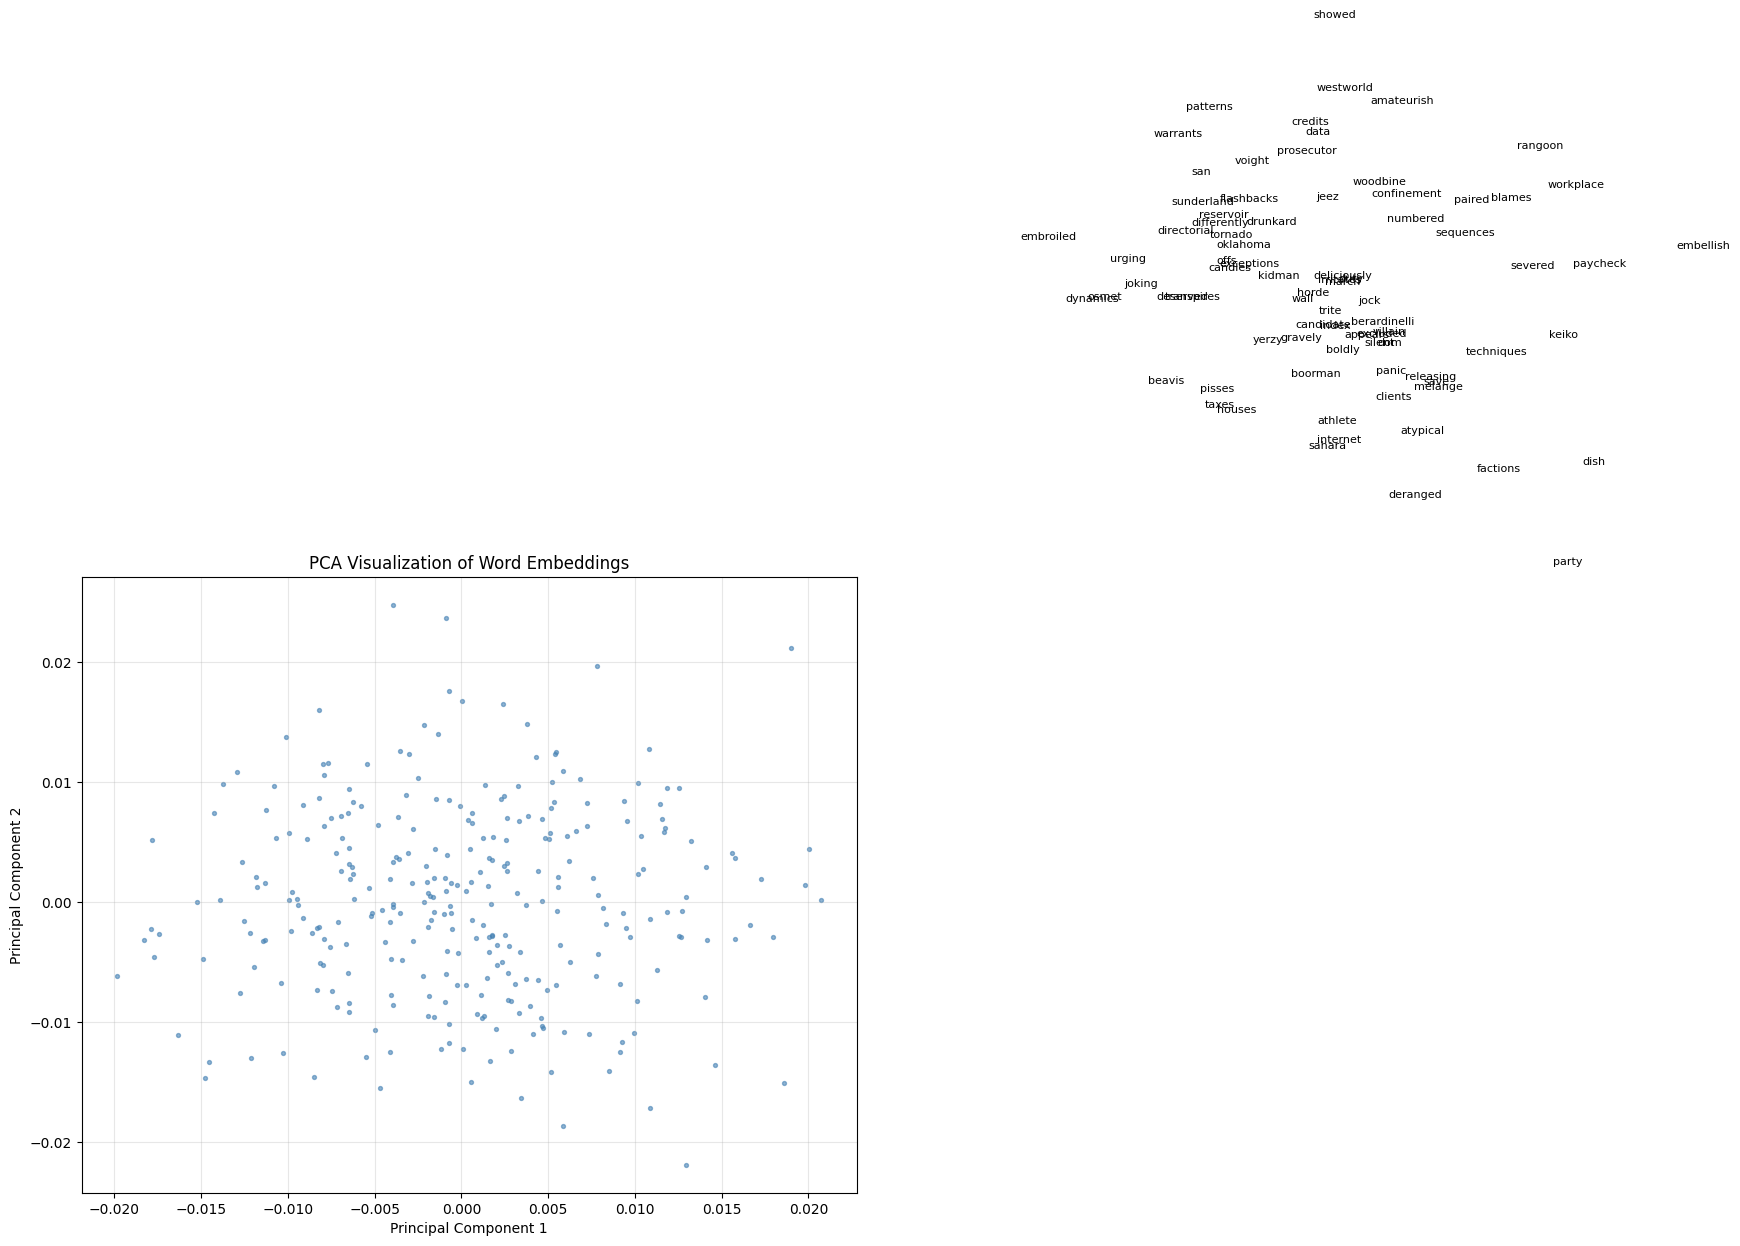

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(subset_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], s=8, alpha=0.6, color='steelblue')
for i, word in enumerate(subset_words[:80]):  # label only a few to keep it readable
    plt.text(pca_result[i, 0] + 0.05, pca_result[i, 1] + 0.05, word, fontsize=8)
plt.title("PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(alpha=0.3)
plt.show()
plt.show()

t-SNE can better capture local clusters of similar embeddings.
We visualize a random subset of the vocabulary to maintain clarity.

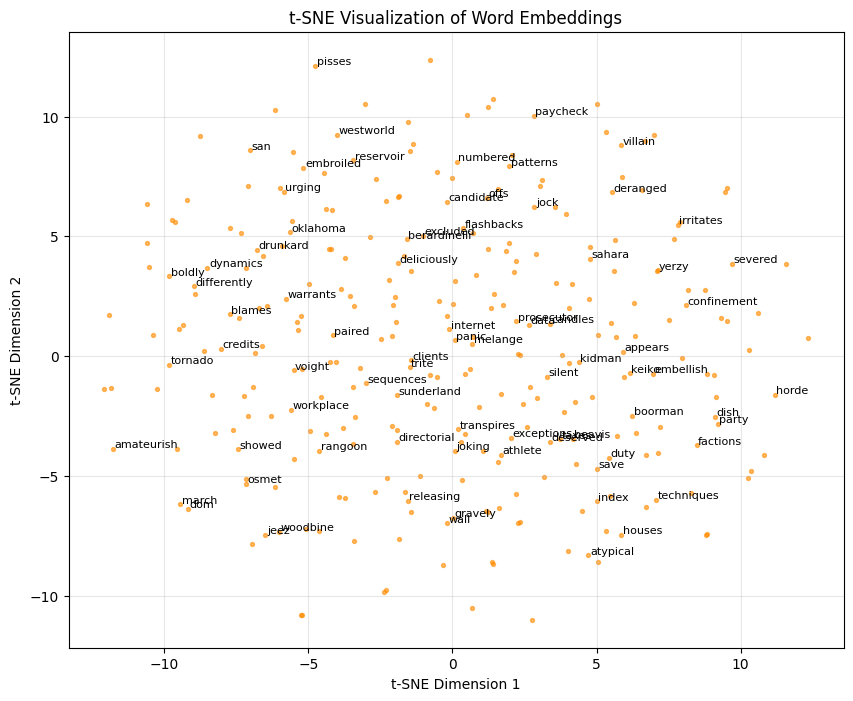

In [25]:
from sklearn.manifold import TSNE

# t-SNE often reveals more local structure (clusters),
# but is slower and non-linear.
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200.0, init='pca', random_state=42)
import numpy as np
subset_vectors = np.asarray(subset_vectors, dtype=np.float64)
tsne_result = tsne.fit_transform(subset_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=8, alpha=0.6, color='darkorange')
for i, word in enumerate(subset_words[:80]):  # label a few words
    plt.text(tsne_result[i, 0] + 0.05, tsne_result[i, 1] + 0.05, word, fontsize=8)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(alpha=0.3)
plt.show()

## 11. Save Embedded Data

In [26]:
import pandas as pd

# Convert numpy arrays into DataFrames
train_df = pd.DataFrame(X_train_seq)
train_df['label'] = y_train  # add target column at the end

test_df = pd.DataFrame(X_test_seq)
test_df['label'] = y_test

# Save as CSV files
train_df.to_csv("dataset/train_embeddings.csv", index=False)
test_df.to_csv("dataset/test_embeddings.csv", index=False)

print("Saved to train_embeddings.csv and test_embeddings.csv")
print("Train shape:", train_df.shape, "Test shape:", test_df.shape)

Saved to train_embeddings.csv and test_embeddings.csv
Train shape: (1600, 201) Test shape: (400, 201)


## 12) Export vocabulary for interactive inference
Finally, we exports a minimal vocabulary file so the model notebook can map raw text to token IDs.
Output: `artifacts/tokenizer_word/tokenizer.json`.

In [27]:
# Export tokenizer vocabulary for Model notebook (no third-party libs)
from pathlib import Path
import json

assert 'tokenizer' in globals(), "Tokenizer not found. Make sure you trained it (fit) above."

out_dir = Path("artifacts/tokenizer_word")
out_dir.mkdir(parents=True, exist_ok=True)

# Build id2word list from tokenizer, supporting both list and dict implementations
id2word = getattr(tokenizer, "id2word", None)
id2word_list = None

if isinstance(id2word, list):
    id2word_list = list(id2word)
elif isinstance(id2word, dict):
    id2word_list = [w for i, w in sorted(id2word.items(), key=lambda x: x[0])]
else:
    # fallback: reconstruct from word2id if possible
    w2i = getattr(tokenizer, "word2id", None)
    if isinstance(w2i, dict):
        id_max = max(w2i.values()) if w2i else -1
        id2word_list = [""] * (id_max + 1)
        for w, i in w2i.items():
            id2word_list[i] = w

assert id2word_list and isinstance(id2word_list, list), "Failed to obtain tokenizer vocabulary."

meta = {
    "type": "word",
    "id2word": id2word_list
}
(out_dir / "tokenizer.json").write_text(json.dumps(meta, ensure_ascii=False, indent=2))
print("Saved vocabulary to", out_dir / "tokenizer.json")
print("Vocab size:", len(id2word_list), "First 10:", id2word_list[:10])


Saved vocabulary to artifacts\tokenizer_word\tokenizer.json
Vocab size: 19779 First 10: ['<PAD>', '<UNK>', 'film', 'extraordinarily', 'horrendous', 'going', 'waste', 'words', 'alex', 'browning']
